<a href="https://colab.research.google.com/github/tommycwong/ML-ElectronMicroscopy-2023/blob/main/Lecture%2013/ML4EM_Summer2023_Mask_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL for Microscopy: Mask R-CNN
Prepared by Tommy Wong, with sections adapted from https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html and from Maxim Ziatdinov enabled by [AtomAI](https://github.com/pycroscopy/atomai). Data made available by Shradha Agarwal.

This notebook demonstrates a simple workflow of using Mask R-CNN to identify defects in TEM images individually by instance segmentation (compare this to U-Net using semantic segmentation).

**To run this notebook, click Runtime -> Run all, and in Change runtime type slect a GPU. Make sure to specify filenames and uncomment cells according to instructions.**

---

Import modules:

In [ ]:
# Note that this is the Pytorch version supported in this notebook.
!pip3 install torch==1.13.0
!pip3 install torchvision==0.14.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.1/890.1 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 74.7 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 1.13.0 which is incompatible.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 1.13.0 which is incompatible.
torchtext 0.15.2 requires torch==2.0.1, but you have torch 1.13.0 which

Import modules:

In [ ]:
# image processing, plotting
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# file management
import pickle
import os
from google.colab import files, drive

# Mask R-CNN is implemented in PyTorch
import torch
import torch.utils.data

It is important to normalize pixels to between 0 and 1 for training with a neural network. Here is a simple function for normalization of a single image:

In [ ]:
def norm2D(img):
    return (img - np.amin(img))/np.ptp(img)

##Generate training data

Download training image and label from GitHub. Mount Google Drive or use `!gdown` instead to access images on Google Drive. Augmentation has to be performed on both images and labels to ensure correspondance.

In [ ]:
# Training images
!wget 'https://raw.githubusercontent.com/SergeiVKalinin/ML-ElectronMicroscopy-2023/main/Lecture%2013/DL_for_Microscopy_Train_Img_1.png'
!wget 'https://raw.githubusercontent.com/SergeiVKalinin/ML-ElectronMicroscopy-2023/main/Lecture%2013/DL_for_Microscopy_Train_Img_2.png'
# Training labels
!wget 'https://raw.githubusercontent.com/SergeiVKalinin/ML-ElectronMicroscopy-2023/main/Lecture%2013/DL_for_Microscopy_Train_Lab_1.xml'
!wget 'https://raw.githubusercontent.com/SergeiVKalinin/ML-ElectronMicroscopy-2023/main/Lecture%2013/DL_for_Microscopy_Train_Lab_2.xml'

--2023-07-18 01:48:15--  https://raw.githubusercontent.com/tommycwong/ML-ElectronMicroscopy-2023/main/Lecture%2013/DL_for_Microscopy_Train_Img_1.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 157118 (153K) [image/png]
Saving to: ‘DL_for_Microscopy_Train_Img_1.png’

DL_for_Microscopy_T 100%[===================>] 153.44K  --.-KB/s    in 0.01s   

2023-07-18 01:48:15 (14.8 MB/s) - ‘DL_for_Microscopy_Train_Img_1.png’ saved [157118/157118]

--2023-07-18 01:48:15--  https://raw.githubusercontent.com/tommycwong/ML-ElectronMicroscopy-2023/main/Lecture%2013/DL_for_Microscopy_Train_Img_2.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubu

Load, normalize, and show the training image and labels with size 512 by 512. The images have dimensions [N, H, W] where N is the number of images. Define a function that does that.

In [ ]:
# A function to generate a stack of images:
def get_imgs(file_list):
    imgs_ = []
    for name in file_list:
        imgs_.append(norm2D(plt.imread(name)))
    # move last axis to 1st so that 1st axis is no. of imgs
    return np.moveaxis(np.dstack(imgs_), -1, 0)

**Create a python list of your training images filenames here:**

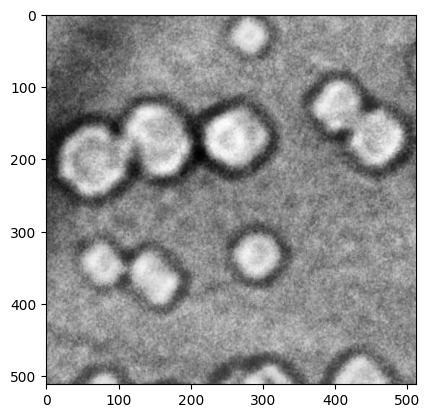

In [ ]:
# Change the filenames of this list to your training data:
train_img_names = ['DL_for_Microscopy_Train_Img_1.png', 'DL_for_Microscopy_Train_Img_2.png']

# Generate a stack of training images:
train_imgs = get_imgs(train_img_names)

# Show the training imgs:
plt.imshow(train_imgs[0], cmap='gist_gray')
plt.imshow(train_imgs[1], cmap='gist_gray')

Define a function to parse the `.xml` files. Takes image and labels filenames as lists and returns a list of annotations.

In [ ]:
#@title `.xml` parser
from lxml import etree

def parse_anno_file(cvat_xml, image_name):
    annos = []
    for i in range(len(cvat_xml)):
        root = etree.parse(cvat_xml[i]).getroot()
        anno = []
        image_name_attr = ".//image[@name='{}']".format(image_name[i])
        for image_tag in root.iterfind(image_name_attr):
                image = {}
                for key, value in image_tag.items():
                    image[key] = value
                image['shapes'] = []
                for poly_tag in image_tag.iter('polygon'):
                    polygon = {'type': 'polygon'}
                    for key, value in poly_tag.items():
                        polygon[key] = value
                    image['shapes'].append(polygon)
                for ell_tag in image_tag.iter('ellipse'):
                    ellipse = {'type': 'ellipse'}
                    for key, value in ell_tag.items():
                        ellipse[key] = value
                    image['shapes'].append(ellipse)
                for box_tag in image_tag.iter('box'):
                    box = {'type': 'box'}
                    for key, value in box_tag.items():
                        box[key] = value
                    box['points'] = "{0},{1};{2},{1};{2},{3};{0},{3}".format(
                        box['xtl'], box['ytl'], box['xbr'], box['ybr'])
                    image['shapes'].append(box)
                image['shapes'].sort(key=lambda x: int(x.get('z_order', 0)))
                anno.append(image)
        annos.append(anno)
    return annos

Parse the `.xml` file and show a sample annotation. **Type your image and labels filenames as lists.**

In [ ]:
xml = ['DL_for_Microscopy_Train_Lab_1.xml', 'DL_for_Microscopy_Train_Lab_2.xml']
annos = parse_anno_file(xml, train_img_names)
print(annos[0][0]) #[0][0] to show eg for 1st img

{'id': '0', 'name': 'DL_for_Microscopy_Train_Img_1.png', 'width': '512', 'height': '512', 'shapes': [{'type': 'polygon', 'label': 'bubble', 'source': 'manual', 'occluded': '0', 'points': '190.29,53.06;190.29,41.21;190.91,31.86;186.55,23.12;177.19,16.26;167.21,13.77;157.23,11.90;147.25,11.27;137.90,12.52;129.16,16.26;120.43,21.25;114.82,29.36;111.07,38.09;111.07,48.70;114.82,57.43;119.81,66.16;127.29,72.40;136.02,76.14;145.38,77.39;154.74,78.64;164.09,78.01;172.83,73.65;183.40,64.30', 'z_order': '0'}, {'type': 'polygon', 'label': 'bubble', 'source': 'manual', 'occluded': '0', 'points': '99.85,57.43;96.10,48.70;94.86,39.34;97.97,29.99;101.09,20.63;108.58,14.39;117.94,13.14;127.29,11.27;137.27,11.27;146.00,15.02;154.74,18.76;162.22,25.00;164.09,34.35;162.22,43.71;157.23,52.44;152.24,61.17;146.63,69.91;136.02,76.77;127.90,76.10;118.56,73.02;106.10,66.20', 'z_order': '0'}, {'type': 'polygon', 'label': 'bubble', 'source': 'manual', 'occluded': '0', 'points': '1.29,58.05;10.65,59.93;20.01,63.

## Process data for Mask R-CNN

Define functions that generate masks and datasets for Mask R-CNN:

In [ ]:
#@title Functions that generate masks and datasets for Mask R-CNN
# must include these modules for functions below
import cv2
import torch

# Creates a mask using parsed annotations. Can be used directly to create mask for U-Net
def create_mask(width, height, shapes):
    mask = np.zeros((height, width), dtype=np.uint8)
    for shape in shapes:
        if shape['type'] == 'polygon':
            points = [tuple(map(float, p.split(','))) for p in shape['points'].split(';')]
            points = np.array([(int(p[0]), int(p[1])) for p in points])
            points = points.astype(int)
            mask = cv2.drawContours(mask, [points], -1, color=1, thickness=-1)
        if shape['type'] == 'ellipse':
            center_coordinates = (int(float(shape['cx'])), int(float(shape['cy'])))
            axesLength = (int(float(shape['rx'])), int(float(shape['ry'])))
            if 'rotation' in shape:
                angle = int(shape['rotation'])
            else:
                angle = 0
            mask = cv2.ellipse(mask, center_coordinates, axesLength, angle,
                               startAngle=0, endAngle=360, color=1, thickness=-1)
    return mask

# Creates bounding boxes
# masks shape = [N, H, W]
def boundbox(masks, maxDim):    # bounding boxes [x1 y1 x2 y2]
    num_objs = len(masks)
    boxes = np.zeros((num_objs, 4))
    for i in range(num_objs):
        pos = np.where(masks[i])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        boxes[i, ...] = np.array([xmin, ymin, xmax, ymax])

    boxes[boxes < 0] = 0 # set negative values to 0
    boxes[boxes > maxDim-1] = maxDim-1 # set values larger than image size to max
    # check for bounding boxes with area != 0:
    boolMask = (boxes[:, 0] != boxes[:, 2]) & (boxes[:, 1] != boxes[:, 3])
    # select masks and boxes with area != 0:
    return torch.as_tensor(boxes[boolMask], dtype=torch.float32), masks[boolMask]

# Generate masks for Mask R-CNN from parsed .xml annotations
# return [N, H, W, C] where N is the no. of images
# and C is the number of features (masks) in each image
def get_maskrcnn_mask(annos):
    single_masks = []
    height = int(annos[0][0]['height']); width = int(annos[0][0]['width'])
    for a in range(len(annos)):
        num_masks = len(annos[a][0]['shapes'])
        single_mask = np.zeros((height, width, num_masks), np.uint8)
        for i in range(num_masks):
            single_mask[..., i] = create_mask(width, height, [annos[a][0]['shapes'][i]])
        single_masks.append(single_mask)
    return single_masks

# Create the dataset in the format [target{boxes, labels, masks}...] and
# valid images in the format [N, H, W]. [target...] has N entries, each target
# has C entries for C features in a single image. labels are int tensor with C entries
# for C features. masks have shape [C, H, W]. boxes have shape [C, 4], each row
# is [x1 y1 x2 y2].
# inputs: images, labels are in np.array([N, H, W, (C)]) where N is the no. of images
# labels have C for the number of features (masks) in each image
# maskdim (int) is the size of the square masks == size of images
def get_maskrcnn_dataset(images, labels):
    train_Y = []
    invalid_imgs = []
    maskdim = images.shape[1]
    for i in range(images.shape[0]):
        box_labs = np.moveaxis(labels[i], -1, 0)
        boundboxes, updatedMasks = boundbox(box_labs, maskdim)
        # check for imgs w/o bounding boxes, skip processing and get idx
        if np.any(boundboxes.cpu().detach().numpy()) == False:
            print(f'invalid image: {i}')
            invalid_imgs.append(i)
            continue
        target = {}
        target["boxes"] = boundboxes
        target["labels"] = torch.as_tensor(np.ones(len(boundboxes)), dtype=torch.int64)
        target["masks"] = torch.as_tensor(updatedMasks, dtype=torch.uint8)
        if len(target["boxes"]) == len(target["labels"]) == len(target["masks"]):
            train_Y.append(target)
            print(f'image {i} has {len(boundboxes)} boxes')
        else:
            print('dictionary entries lengths do not match')
            break
    # select only images with labels
    valid_images = np.delete(images, invalid_imgs, axis=0)
    return valid_images, train_Y

Generate the labels for Mask R-CNN instance segmentation. Masks have dimensions [N, H, W, C] where N is the no. of images and C is the number of features (masks) in each image, and pixel values of either 0 (for background) and 1 (for features). We will need the masks specifically for sliding window cropping.

In [ ]:
maskRcnn_masks = get_maskrcnn_mask(annos)

Show the Mask R-CNN mask:

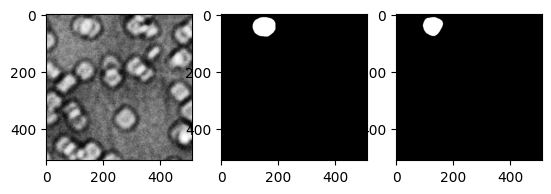

In [ ]:
#@title Show the mask:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(train_imgs[0], cmap='gist_gray')
ax[1].imshow(maskRcnn_masks[0][...,0], cmap='gist_gray')
ax[2].imshow(maskRcnn_masks[0][...,1], cmap='gist_gray')

Save the images and masks as pickle files for easy manipulation. **Uncomment entire cell to save processed images and masks. Change the filenames below.**

In [ ]:
#import pickle
#with open('DL_for_Microscopy_Train_Img_12_maskRcnn_mask.pickle', 'wb') as f:
#    pickle.dump(maskRcnn_masks, f)
#f.close()

Using the masks we just created, create the dataset in the format [target{boxes, labels, masks}...] and valid images in the format [N, H, W]. [target...] has N entries, each target has C entries for C features in a single image. labels are int tensor with C entries for C features. masks have shape [C, H, W]. boxes have shape [C, 4], each row is [x1 y1 x2 y2]. Inputs: images, labels are in np.array([N, H, W, (C)]) where N is the no. of images and labels have C for the number of features (masks) in each image.

In [ ]:
train_imgs, maskRcnn_labels = get_maskrcnn_dataset(images=train_imgs, labels=maskRcnn_masks)

image 0 has 37 boxes
image 1 has 14 boxes


Show the bounding boxes:

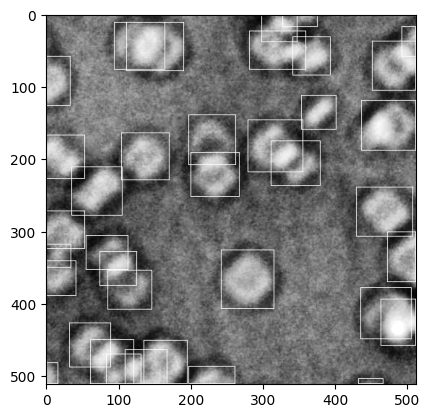

In [ ]:
#@title Show drawn boxes:
import cv2
drawn_img = np.copy(train_imgs[0])
for i in range(len(maskRcnn_labels[0]["boxes"])):
    pred2Dboxed = cv2.rectangle(drawn_img,
                                maskRcnn_labels[0]["boxes"].numpy()[i, 0:2].astype(int),
                                maskRcnn_labels[0]["boxes"].numpy()[i, 2:4].astype(int), color=1)
plt.imshow(pred2Dboxed, cmap = 'gist_gray')

Mount Google drive to save. **Uncomment entire cell to mount Google Drive. Type the path to your save directory below.**

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#import os
#directory = 'path to your Google drive directory here'
#os.chdir(directory)

Save the images as numpy files for easy manipulation. The labels have to be saved as `.pickle` files due to the data structure. **Uncomment entire cell to save processed images and masks. Change the filenames below.**

In [ ]:
# Save processed images
#np.save('DL_for_Microscopy_Train_eg_img', train_imgs)

# Save Mask R-CNN dataset
#import pickle
#with open('DL_for_Microscopy_Train_eg_img_maskRcnn_data.pickle', 'wb') as f:
#    pickle.dump(maskRcnn_labels, f)
#f.close()

## Sliding window cropping

Define functions for cropping. Cropping using a sliding window allows small amount of microscopy data to be diversified into more data for training. Convolutional neural networks (CNNs) also do not perform well with extremely large images common in microscopy. Two slightly different cropping functions are provided for U-Net and Mask R-CNN: `unet_cropper` and `maskRcnn_cropper`.

In [ ]:
#@title Cropping functions:
import numpy as np

class cropper:
    """
    Augments an input image-mask pair by performing image cropping procedure
    """
    def __init__(self, image, mask, window_size, step_size):
        """
        Args:
            image (2d ndarray): image to be cropped (height x width),
            mask (3d ndarray): mask/ground truth (height x width x channels),
            window_size (tuple): width and height of sliding window,
            step_size (float): step size of sliding window,
            batch_size (int): number of images to return.
        """
        if np.ndim(image) == 2:
            image = np.expand_dims(image, axis=2)
        self.image = image
        if np.ndim(mask) == 2:
            mask = np.expand_dims(mask, axis=2)
        self.mask = mask
        self.window_size = window_size
        self.step_size = step_size

    def sliding_window(self):
        """
        Returns the portion of the input image lying within sliding window
        """
        for y in range(0, self.image.shape[0], self.step_size):
            for x in range(0, self.image.shape[1], self.step_size):
                yield (self.image[y:y + self.window_size[1], x:x + self.window_size[0], :],
                       self.mask[y:y + self.window_size[1], x:x + self.window_size[0], :])

    def imgen(self):
        """
        Returns a batch of cropped images and
        a batch of corresponding labels (ground truth)
        """
        X_batch = np.empty((0, self.window_size[0], self.window_size[1]))
        y_batch = []
        for window in self.sliding_window():
            if window[0].shape[: -1] != self.window_size:
                continue
            window_i = np.transpose(window[0], [2, 0, 1])   # img
            window_i = (window_i - np.amin(window_i))/np.ptp(window_i) # normalize img
            window_l = np.transpose(window[1], [2, 0, 1])   # lab
            # remove masks w/o bubbles
            window_l = window_l[np.any(window_l != 0, axis=(1, 2))]
            X_batch = np.append(X_batch, window_i, axis=0)
            y_batch.append(window_l)
        if len(X_batch) != len(y_batch):
            return 'no. of image patches does not match no. of label patches'
        return X_batch, y_batch

    def norm2D(img):
        return (img - np.amin(img))/np.ptp(img)

def maskRcnn_cropper(img, mask, window_size, step_size):
    """
    input:
    img, mask in np.array([N, H, W]) where N is no. of imgs/masks
    window_size, step_size: int, square windows with stride of step_size
    return:
    img_patches in np.array([N, H, W]) where N is no. of patches
    lab_patches as list with N np.array([H, W, C]) where C is no. of features/img
    """
    img_patches = []; lab_patches = []
    for i in range(len(img)):
        imcrop = cropper(img[i], mask[i], (window_size, window_size), step_size)
        img_patch, lab_patch = imcrop.imgen()
        img_patches.append(img_patch)
        lab_patches.append(lab_patch)
    img_patches = np.vstack(img_patches)
    lab_patches = [item for sublist in lab_patches for item in sublist]
    lab_patches_ = []
    for l in lab_patches:
        lab_patches_.append(np.moveaxis(l, 0, -1))
    return img_patches, lab_patches_

### Mask R-CNN cropping:

**Specify filename** and load the Mask R-CNN masks. **Uncomment entire cell to load the Mask R-CNN masks. Change the filenames below.**

In [ ]:
#import pickle
#maskRcnn_mask_file = open('DL_for_Microscopy_Train_Img_12_maskRcnn_mask.pickle', 'rb')
#maskRcnn_mask = pickle.load(maskRcnn_mask_file)
#maskRcnn_mask_file.close()

Crop the Mask R-CNN images/masks into patches of 256 by 256 with step size/stride of 128 (half of window size):

**Note that the second argument only takes in the masks (generated previously)**

In [ ]:
maskRcnn_img_patches, maskRcnn_mask_patches = maskRcnn_cropper(train_imgs, maskRcnn_masks, window_size=256, step_size=128)

Display a few cropped patches. Note the labels displayed are overlays of individual feature labels.

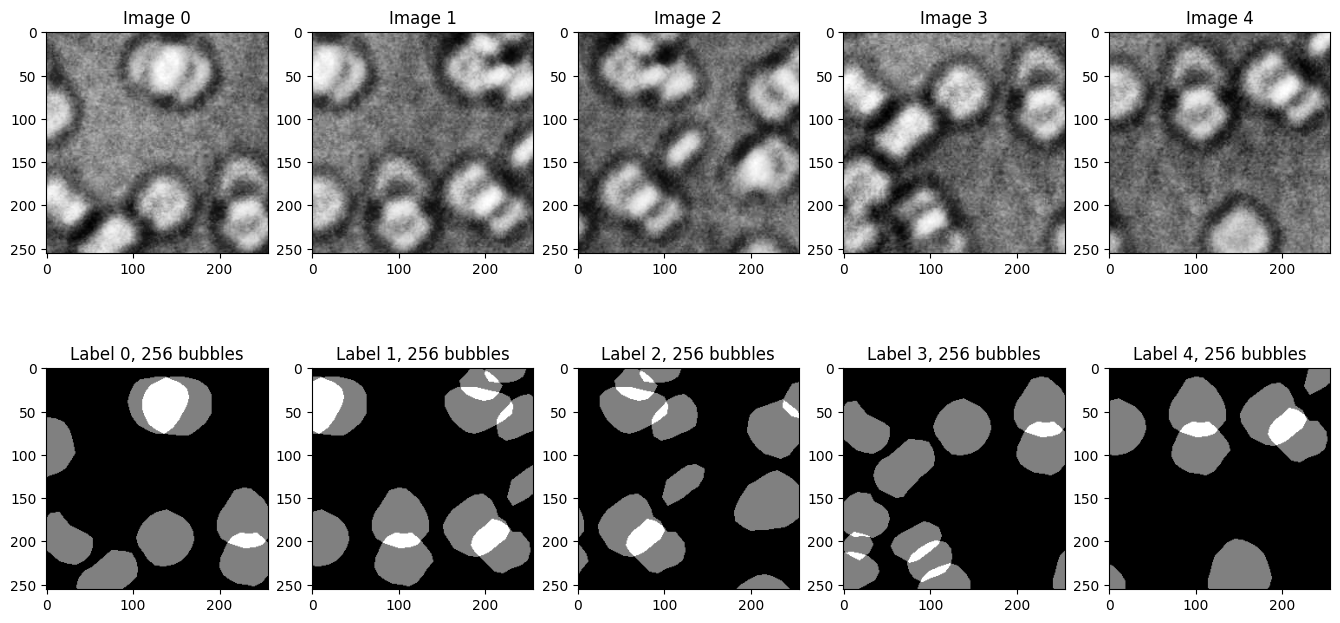

In [ ]:
#@title Show cropped Mask R-CNN patches:
# No of image-label pairs to be displayed
n = 5
n = n + 1

fig = plt.figure(figsize=(20, 8))
for i in range(1, n):
    ax = fig.add_subplot(2, n, i)
    ax.imshow(maskRcnn_img_patches[i-1,...], cmap = 'gist_gray')
    ax.set_title(f'Image {str(i-1)}')
    ax = fig.add_subplot(2, n, i+n)
    ax.imshow(np.sum(maskRcnn_mask_patches[i-1], axis=-1), cmap = 'gist_gray')
    ax.set_title(f'Label {str(i-1)}, {len(maskRcnn_mask_patches[i-1])} bubbles')

Generate Mask R-CNN dataset:

In [ ]:
maskRcnn_train_imgs, maskRcnn_train_labels = get_maskrcnn_dataset(images=maskRcnn_img_patches, labels=maskRcnn_mask_patches)

image 0 has 8 boxes
image 1 has 12 boxes
image 2 has 13 boxes
image 3 has 12 boxes
image 4 has 8 boxes
image 5 has 10 boxes
image 6 has 15 boxes
image 7 has 6 boxes
image 8 has 7 boxes
image 9 has 3 boxes
image 10 has 4 boxes
image 11 has 5 boxes
image 12 has 5 boxes
image 13 has 5 boxes
image 14 has 4 boxes
image 15 has 4 boxes
image 16 has 4 boxes
image 17 has 4 boxes


Mount Google Drive to save files:

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#import os
#directory = 'your path here'
#os.chdir(directory)

Save the numpy and pickle files:

In [ ]:
# Save processed images
#np.save('DL_for_Microscopy_mrcnn_train_imgs', maskRcnn_train_imgs)
# Save Mask R-CNN dataset
#import pickle
#with open('DL_for_Microscopy_mrcnn_train_labs.pickle', 'wb') as f:
#    pickle.dump(maskRcnn_train_labels, f)
#f.close()

## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.


One note on the labels. The model considers class 0 as background. If your dataset does not contain the background class, you should not have 0 in your labels. For example, assuming you have just two classes, cat and dog, you can define 1 (not 0) to represent cats and 2 to represent dogs. So, for instance, if one of the images has both classes, your labels tensor should look like [1,2].

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


### Writing a custom dataset for our data

Let's write a dataset for our dataset.

The following 2 cells allow uploading your own data for training. Uncomment the following cells and specify your download link and file path to load in training data using `!wget` or `!gdown` to download data from GitHub and Google Drive respectively.

Download training/test data:

In [ ]:
# Training data
#!wget 'https://raw.githubusercontent.com/shradhautk/AI-MICROSCOPY-WORKSHOP/main/Day2_Education_Day/CNN_tutorial/DL_for_Microscopy_mrcnn_train_imgs.npy'
#!wget 'https://raw.githubusercontent.com/shradhautk/AI-MICROSCOPY-WORKSHOP/main/Day2_Education_Day/CNN_tutorial/DL_for_Microscopy_mrcnn_train_labs.pickle'

Load data:

In [ ]:
# train data
#train_images = np.load('DL_for_Microscopy_mrcnn_train_imgs.npy')
#labels_dict_file = open('DL_for_Microscopy_mrcnn_train_labs.pickle', 'rb')
#labels_dict = pickle.load(labels_dict_file)
#labels_dict_file.close()

Since we have already prepared the training data above, we do not need to upload data from external sources. We process the training data below.

In [ ]:
# train data
train_images = maskRcnn_train_imgs
labels_dict = maskRcnn_train_labels

Sample training image:

1.0

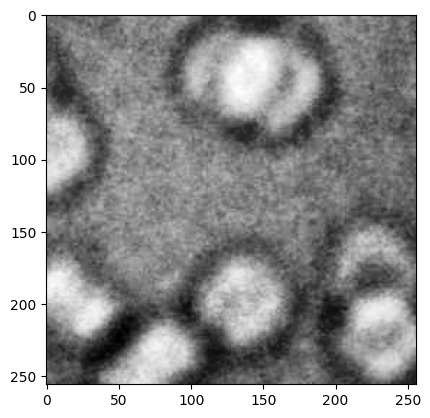

In [ ]:
plt.imshow(train_images[0], cmap='gist_gray')
train_images[0].max()

Sample training mask:

Note that this is an aggregate of all the individual masks for the above subimage.

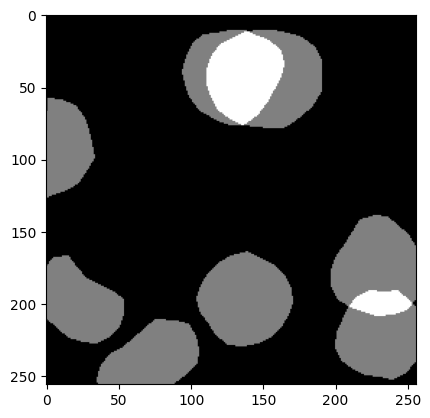

In [ ]:
mask = np.sum(labels_dict[0]['masks'].numpy(), axis=0)
plt.imshow(mask, cmap='gist_gray')

### Testing data
Download and load testing data:

In [ ]:
# Data for prediction
!wget 'https://raw.githubusercontent.com/SergeiVKalinin/ML-ElectronMicroscopy-2023/main/Lecture%2013/test_image.png' # image
!wget 'https://raw.githubusercontent.com/SergeiVKalinin/ML-ElectronMicroscopy-2023/main/Lecture%2013/test_label.png' # labels

# Read testing data as numpy arrays
test_image = plt.imread('test_image.png')
test_label = plt.imread('test_label.png')

--2023-07-18 01:48:21--  https://raw.githubusercontent.com/tommycwong/ML-ElectronMicroscopy-2023/main/Lecture%2013/test_image.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 161901 (158K) [image/png]
Saving to: ‘test_image.png’

test_image.png      100%[===================>] 158.11K  --.-KB/s    in 0.01s   

2023-07-18 01:48:21 (13.0 MB/s) - ‘test_image.png’ saved [161901/161901]

--2023-07-18 01:48:21--  https://raw.githubusercontent.com/tommycwong/ML-ElectronMicroscopy-2023/main/Lecture%2013/test_label.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiti

So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let's write a `torch.utils.data.Dataset` class for this dataset. This might look complicated but if you run all previous cells, this cell will run without any inputs. It automatically generate the dataset in the correct structure.

In [ ]:
#@title Dataset constructor:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, transforms=None):
        self.transforms = transforms
        # load all image files
        self.imgs = train_images
        self.labels_dict = labels_dict

    def __getitem__(self, idx):
        # load images and masks, image has to be PIL
        img = Image.fromarray(np.uint8(self.imgs[idx]/np.max(self.imgs[idx])*255))
        masks = self.labels_dict[idx]['masks']

        # get bounding box coordinates for each mask
        boxes = self.labels_dict[idx]['boxes']

        num_objs = len(self.labels_dict[idx]['labels'])

        labels =  self.labels_dict[idx]['labels']

        image_id = torch.tensor([idx])

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

That's all for the dataset. Let's see how the outputs are structured for this dataset

In [ ]:
dataset = TrainDataset()
dataset[0]

(<PIL.Image.Image image mode=L size=256x256 at 0x7E8A96C0AAA0>,
 {'boxes': tensor([[111.,  11., 190.,  78.],
          [ 94.,  11., 164.,  76.],
          [  0.,  58.,  33., 126.],
          [104., 164., 170., 229.],
          [  0., 167.,  53., 227.],
          [ 35., 211., 105., 255.],
          [200., 191., 255., 252.],
          [197., 139., 255., 208.]]),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

## Defining your model

In this tutorial, we will be using [Mask R-CNN](https://arxiv.org/abs/1703.06870), which is based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

### An Instance segmentation model for He Bubble Dataset

An important parameter to change here is the **number of hidden layers**. The more layers the network has, the more complicated it becomes and the longer it takes to train, but it should become more accurate.

We can fine-tune from a pre-trained model, given that our dataset is very small. This is known as transfer learning.

Here we want to also compute the instance segmentation masks, so we will be using Mask R-CNN:

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_instance_segmentation_model(hidden_layer=32, num_classes=2):
    # load an instance segmentation model pre-trained on COCO
    # v2 is a newer version
    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [ ]:
#@title Download helper functions:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 348883, done.
remote: Counting objects: 100% (65115/65115), done.
remote: Compressing objects: 100% (1896/1896), done.
remote: Total 348883 (delta 63848), reused 64291 (delta 63166), pack-reused 283768
Receiving objects: 100% (348883/348883), 701.11 MiB | 31.71 MiB/s, done.
Resolving deltas: 100% (321699/321699), done.
Note: switching to 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)




It is also possible to perform augmentation while feeding in data to the network. Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied (here a simple horizontal flip was performed):


In [ ]:
#@title Transform function:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

### Train the model:

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [ ]:
# use our dataset and defined transformations
dataset = TrainDataset(get_transform(train=True))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer. The important parameters include the hidden layer, learning rate, choice of optimizer.

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# no. of hidden layers
hidden_layer = 32

# get the model using our helper function
model = get_instance_segmentation_model(hidden_layer)
# move model to the right device (GPU)
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001)
# This decreases the lr exponentially during training
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth


  0%|          | 0.00/177M [00:00<?, ?B/s]

And now let's train the model. **Select your number of epochs here.**

In [ ]:
# Define no. of epochs:
from torch.optim.lr_scheduler import StepLR
num_epochs = 50

# Name of model to be saved

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

    # update the learning rate
    lr_scheduler.step()

Epoch: [0]  [0/9]  eta: 0:00:31  lr: 0.000126  loss: 2.3237 (2.3237)  loss_classifier: 0.6823 (0.6823)  loss_box_reg: 0.2022 (0.2022)  loss_mask: 0.7971 (0.7971)  loss_objectness: 0.4951 (0.4951)  loss_rpn_box_reg: 0.1471 (0.1471)  time: 3.5539  data: 0.1512  max mem: 3796
Epoch: [0]  [8/9]  eta: 0:00:00  lr: 0.001000  loss: 1.8696 (1.6671)  loss_classifier: 0.4932 (0.4265)  loss_box_reg: 0.3980 (0.4657)  loss_mask: 0.3680 (0.4265)  loss_objectness: 0.1022 (0.2974)  loss_rpn_box_reg: 0.0259 (0.0509)  time: 0.5979  data: 0.0243  max mem: 4262
Epoch: [0] Total time: 0:00:05 (0.6032 s / it)
Epoch: [1]  [0/9]  eta: 0:00:03  lr: 0.000500  loss: 0.7088 (0.7088)  loss_classifier: 0.1120 (0.1120)  loss_box_reg: 0.3629 (0.3629)  loss_mask: 0.1756 (0.1756)  loss_objectness: 0.0386 (0.0386)  loss_rpn_box_reg: 0.0197 (0.0197)  time: 0.4227  data: 0.1945  max mem: 4262
Epoch: [1]  [8/9]  eta: 0:00:00  lr: 0.000500  loss: 0.8980 (0.8897)  loss_classifier: 0.1629 (0.1603)  loss_box_reg: 0.3917 (0.408

### Perform prediction:
Now that training has finished, let's have a look at what it actually predicts in a test image. The image first has to be expanded into `[C, H, W]` format.

In [ ]:
# pick image for testing
img = torch.from_numpy(test_image[None, ...])

# put the model in evaluation mode
# there is only 1 image hence we index the 1st prediction (given as a list)
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

Let's inspect the image and the predicted segmentation masks.

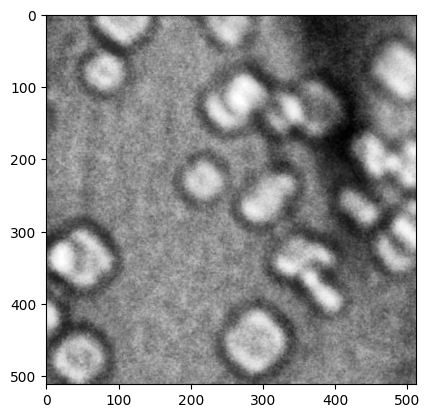

In [ ]:
plt.imshow(test_image, cmap='gray')

And let's now visualize the top predicted segmentation masks. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1. The prediction masks are arranged in descending order of confidence score from 0-1. The highest score being the prediction with the highest fidelity.

Prediction shape:  torch.Size([39, 1, 512, 512])


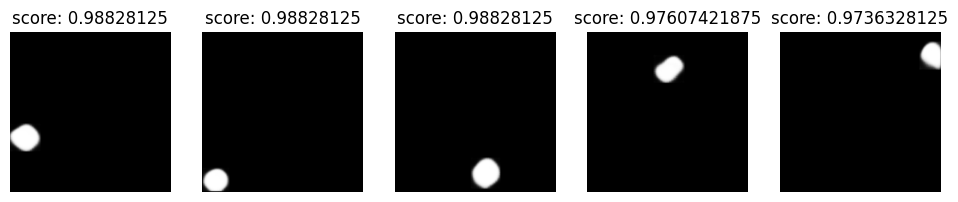

In [ ]:
print('Prediction shape: ', prediction['masks'].shape)
# ['masks'][N, 0] where N is the number of predictions
fig, ax = plt.subplots(1, 5, figsize=(12,12))
for i in range(5):
    score = prediction['scores'][i].cpu().numpy().astype('float16')
    ax[i].set_title(f'score: {score}')
    ax[i].imshow(prediction['masks'][i, 0].mul(255).byte().cpu().numpy(), cmap='gist_gray')
    ax[i].axis('off')

Since predictions with low scores are much lower in quality, select those with scores above 0.7 and overlap the predictions:

In [ ]:
#@title Create color masks:
# create a mask showing individual identifications in different colors
import colorsys
scores = prediction['scores'].cpu().numpy()
num_preds = len(scores[scores > 0.7])
height = prediction['masks'].shape[2]; width = prediction['masks'].shape[3]
colourmasks = np.zeros((num_preds, height, width, 3))
hues = np.linspace(0.01, 0.99, num_preds)
rng = np.random.default_rng(seed=41)
hues = rng.permuted(hues)

for i in range(num_preds):
    mask_i = prediction['masks'][i].cpu().numpy()
    mask_i[mask_i > .5] = 1
    mask_i[mask_i <= .5] = 0
    colorRGB = colorsys.hsv_to_rgb(hues[i], 1., 1.)
    mask3d_i = np.full((mask_i.shape[1], mask_i.shape[2], 3), mask_i[..., None])
    mask3d_i[..., 0] = mask3d_i[..., 0] * colorRGB[0]
    mask3d_i[..., 1] = mask3d_i[..., 1] * colorRGB[1]
    mask3d_i[..., 2] = mask3d_i[..., 2] * colorRGB[2]
    colourmasks[i] = mask3d_i
color_results = norm2D(np.sum(colourmasks, axis=0))

# collapse the mask into 1 channel to perform IoU calculations
pred_results = np.sum(color_results, axis=-1)
pred_results[pred_results > .1] = 1

Let's compare the predictions to the ground truth of the above image. The most common accuracy metric is the IoU score and it is implemented in PyTorch (TorchMetrics). (Image from Wikipedia)

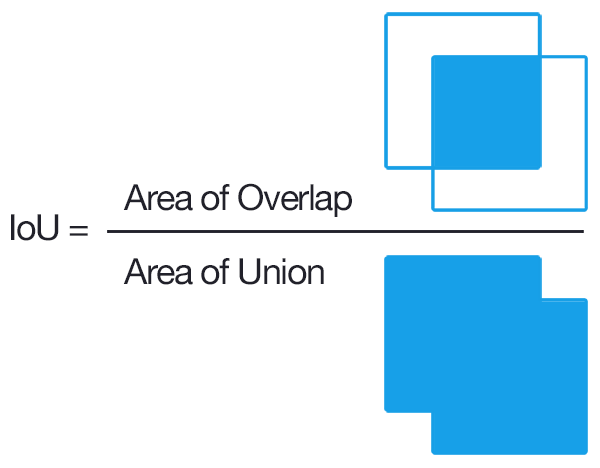

Install torchmetrics:

In [ ]:
import torch
!pip3 install torchmetrics==0.10.0 # need to match version of PyTorch used
import torchmetrics
from torchmetrics import classification

Calculate the IoU and show visual comparison:

IoU:  0.6524559259414673


Text(0.5, 1.0, 'Prediction results')

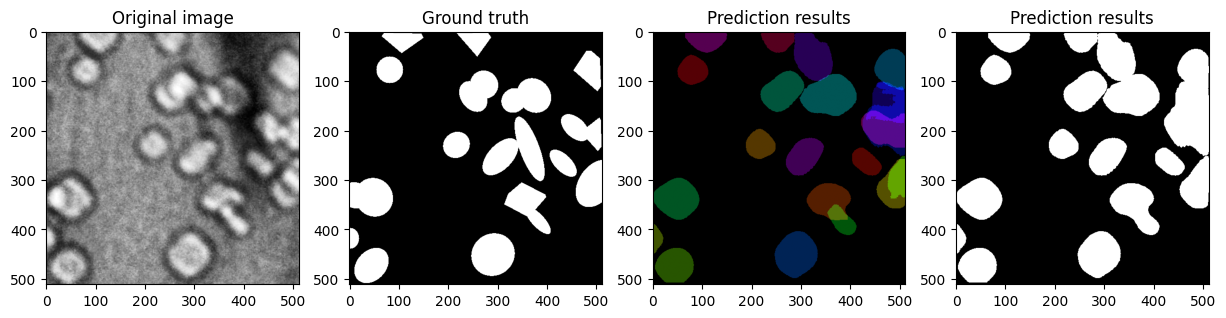

In [ ]:
metric = classification.BinaryJaccardIndex()
print('IoU: ', metric(torch.as_tensor(pred_results), torch.as_tensor(test_label)).item())

_, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(15, 15))
ax0.imshow(test_image, cmap='gray')
ax0.set_title('Original image')
ax1.imshow(test_label, cmap='gray')
ax1.set_title('Ground truth')
ax2.imshow(color_results, cmap='gray')
ax2.set_title('Prediction results')
ax3.imshow(pred_results, cmap='gray')
ax3.set_title('Prediction results')